# Лабораторная работа 3. Полиномиальная регрессия. Регуляризация

### Задание 1. Полиномиальная регрессия

Загрузите данные из файлов `ml_lab1_train.txt` и `ml_lab1_test.txt` (первая лабораторная работа).

Для $k = 1,2,3,\ldots,10$ найдите полином ${f}_k$ степени $k$, наилучшим образом приближающий неизвестную зависимость.

Выведите коэффициенты полиномов и нарисуйте их графики на одном чертеже вместе с точками данных $(x_i, y_i)$ (возможно, чертеж стоит сделать побольше; это делается командой `plt.figure(figsize=(width, height))`).

Для каждого из полиномов найдите среднеквадратическую ошибку $MSE$ и коэффициент детерминации $R^2$ на обучающих данных и на тестовых данных. Постройте графики зависимости $MSE$ на обучающих и тестовых данных в зависимости от степени полинома (должно быть три графика: один для обучающих данных, второй – для тестовых, третий – для обоих видов данных вместе).

Сделайте вывод, что происходит с ошибкой на обучающих и тестовых данных с увеличением степени полинома.

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

def find_polynomial_coefficients(train_data, polynomial_degree):
    X = np.array([train_data["x"] ** i for i in range(polynomial_degree + 1)]).T
    y = np.array(train_data["y"])
    coefficients = np.linalg.inv(X.T @ X) @ X.T @ y
    return coefficients

def find_polynomial_regression(x, coefficients):
    return np.array([sum([coefficients[i] * x_i ** i for i in range(k + 1)]) for x_i in x])


In [72]:
train_data = pd.read_csv('ml_lab1_train.txt', header=None, names=['x', 'y'])
test_data = pd.read_csv('ml_lab1_test.txt', header=None, names=['x', 'y'])

max_k = 10
x_min = np.concatenate((train_data['x'], test_data['x'])).min()
x_max = np.concatenate((train_data['x'], test_data['x'])).max()

mse_train_values = []
mse_test_values = []

k = 1, coefficients = [4.43323091 2.2791345 ]
MSE for train data with k = 1: 0.2968966332625196
MSE for test data with k = 1: 0.4351202004048882
R2 for train data with k = 1: 0.6978349896117897
R2 for test data with k = 1: 0.6848801332179667
k = 2, coefficients = [4.4724765  1.15783169 1.40162851]
MSE for train data with k = 2: 0.2696989158766914
MSE for test data with k = 2: 0.35647628878312104
R2 for train data with k = 2: 0.7255153255796204
R2 for test data with k = 2: 0.7418351055001289
k = 3, coefficients = [ 4.46073636  1.06501611  1.85975084 -0.3817686 ]
MSE for train data with k = 3: 0.26949718714796106
MSE for test data with k = 3: 0.35534645715183033
R2 for train data with k = 3: 0.7257206339482016
R2 for test data with k = 3: 0.7426533446735968
k = 4, coefficients = [  4.34116612   1.17180239   6.79409178 -13.05132812   7.9184747 ]
MSE for train data with k = 4: 0.2610665330579276
MSE for test data with k = 4: 0.4417270189284551
R2 for train data with k = 4: 0.73430088847214

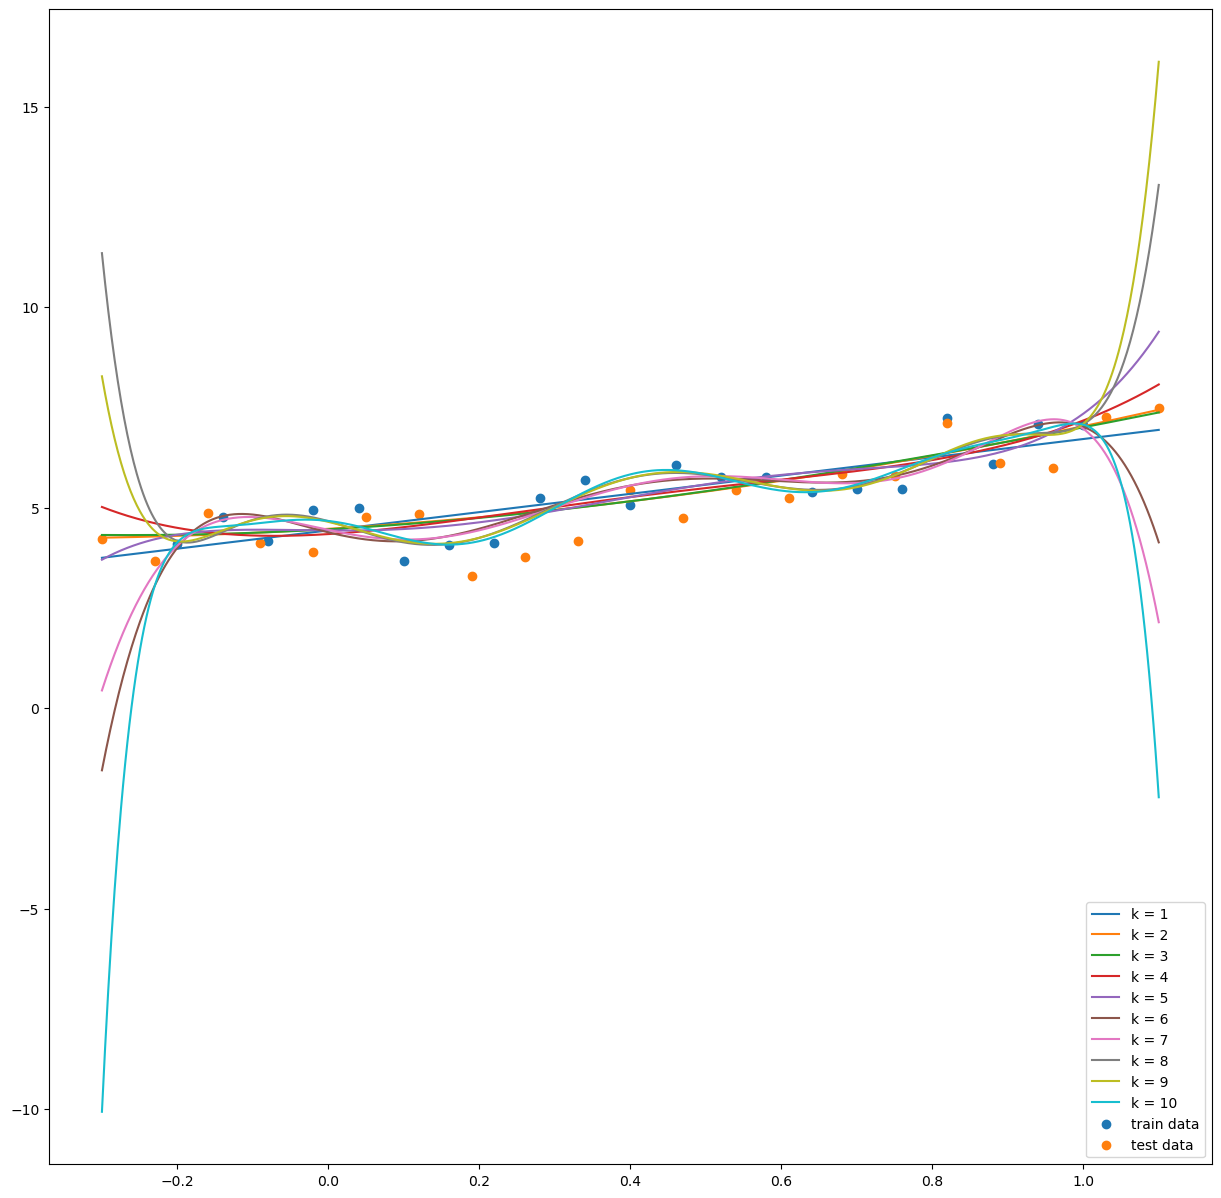

In [73]:
plt.figure(figsize=(15, 15))

for k in range(1, max_k + 1):
    coefficients = find_polynomial_coefficients(train_data, k)
    print(f'k = {k}, coefficients = {coefficients}')
    
    x = np.linspace(x_min, x_max, 1000)
    y = find_polynomial_regression(x, coefficients)
    
    mse_train = mean_squared_error(train_data['y'], find_polynomial_regression(train_data['x'], coefficients))
    mse_test = mean_squared_error(test_data['y'], find_polynomial_regression(test_data['x'], coefficients))
    print(f"MSE for train data with k = {k}: {mse_train}")
    print(f"MSE for test data with k = {k}: {mse_test}")
    mse_train_values.append(mse_train)
    mse_test_values.append(mse_test)
    
    r2_train = r2_score(train_data['y'], find_polynomial_regression(train_data['x'], coefficients))
    r2_test = r2_score(test_data['y'], find_polynomial_regression(test_data['x'], coefficients))
    print(f"R2 for train data with k = {k}: {r2_train}")
    print(f"R2 for test data with k = {k}: {r2_test}")
    
    plt.plot(x, y, label=f'k = {k}')

plt.scatter(train_data['x'], train_data['y'], label='train data')
plt.scatter(test_data['x'], test_data['y'], label='test data')
plt.legend()
plt.savefig('polynomial_regression.png')

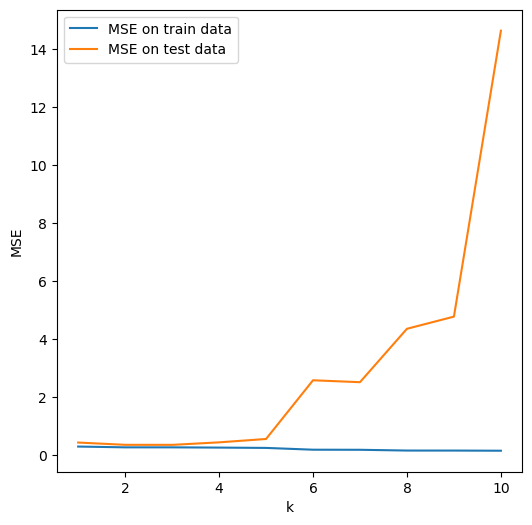

In [74]:
plt.figure(figsize=(6, 6))
plt.plot(range(1, max_k + 1), mse_train_values, label='MSE on train data')
plt.plot(range(1, max_k + 1), mse_test_values, label='MSE on test data')
plt.legend()
plt.xlabel('k')
plt.ylabel('MSE')
plt.show()

### Задание 2. Регуляризация

Вспомним, что задачу линейной регрессии (нахождение вектора коэффициентов $\overrightarrow{w}_{opt}$) можно решить при помощи нормального уравнения:

$$\overrightarrow{w}_{opt} = \left(X^TX\right)^{-1}X^T\overrightarrow{y}.$$

Если строки или столбцы матрицы $X$ линейно зависимы, то матрица $X^TX$ вырожденна и задача не может быть решена с помощью нормального уравнения (придется использовать, например, градиентный спуск). На практике различные признаки редко бывают *в точности* линейно зависимы, однако во многих ситуациях они скоррелированы и становятся "почти" линейно зависимыми. Таковы, к примеру, зарплата человека, его уровень образования, цена машины и суммарная площадь недвижимости, которой он владеет. В этом случае матрица $X^TX$ будет близка к вырожденной, и это приводит к численной неустойчивости и плохому качеству решений; как следствие, будет иметь место *переобучение* (overfitting). Один из симптомов этой проблемы – необычно большие по модулю компоненты вектора $\overrightarrow{w}_{opt}$.

Один из способов борьбы с переобучением – **регуляризация**. Сейчас мы рассмотрим одну из её разновидностей – **L2-регуляризацию**. Идея в том, чтобы подправить матрицу $X^TX$, сделав её "получше". Например, это можно сделать, заменив её на $(X^TX + \alpha I)$, где $\alpha$ – параметр регуляризации, $I$ – единичная матрица. Пожертвовав точностью на обучающей выборке, мы тем не менее получаем численно более стабильное псевдорешение:

$$\overrightarrow{w}_{opt} = (X^TX + \alpha I)^{-1}X^T\overrightarrow{y}$$

и снижаем эффект переобучения. Параметр $\alpha$ нужно подбирать, и каких-то универсальных способов это делать нет, но зачастую можно его подобрать таким, чтобы ошибка на тестовой выборке падала. 

Теперь давайте вспомним первую задачу. Если вы её сделали, то помните, что ошибка аппроксимации полиномом шестой степени довольно высокая. Убедитесь, что, используя регуляризацию с хорошо подобранным параметром $\alpha$, ошибку на тестовой выборке можно сделать не больше, чем для полинома оптимальной степени в модели без регуляризации. Для этого $\alpha$ сравните $\det(X^TX)$ и $\det(X^TX + \alpha I)$.

Изобразите на графике три полинома: полином оптимальной степени без регуляризации, полином шестой степени без регуляризации и полином шестой степени с регуляризацией.

In [75]:
# Ваш код здесь

### Задание 3. Линейная регрессия в scikit-learn

Скачайте файлы ``flats_moscow.txt`` и ``flats_moscow_description.pdf``. В первом из них содержатся данные о квартирах в Москве. Каждая строка содержит шесть характеристик некоторой квартиры, разделённые знаками табуляции; в первой строке записаны кодовые названия характеристик. Во втором файле приведены краткие описания признаков. Вашей задачей будет построить с помощью линейной регрессии зависимость между ценой квартиры и остальными доступными параметрами.

Построив несколько моделей, нужно сравнить их качество. Проверять это на той же выборке, на которой вы обучались, бессмысленно и даже вредно (вспомните пример с полиномами: как хорошо падала ошибка на обучающей выборке с ростом степени и как быстро росла ошибка на тестовых данных!). Поэтому вам нужно будет разделить выборку на обучающую и тестовую. Делать это лучше случайным образом (ведь вы не знаете, как создатели набора данных упорядочили объекты); рекомендуем вам для этого функцию `sklearn.model_selection.train_test_split`.

Постройте следующие модели линейной регрессии по методу наименьших квадратов:

1. на основе собственной функции (нормальное уравнение);

1. с L2-регуляризацией на основе собственной функции – параметр регуляризации нужно подобрать;

1. собственную реализацию полиномиальной регрессии – степень полинома нужно подобрать;

1. на основе функции `LinearRegression` из `scikit-learn`;

1. с L2-регуляризацией на основе функции `Ridge` из `scikit-learn` – параметр регуляризации нужно подобрать;

1. с L1-регуляризацией на основе функции `Lasso` из `scikit-learn` – параметр регуляризации нужно подобрать.

Выведите и сравните регрессионные коэффициенты для всех функций. Какой смысл имеют их знаки? Согласуются ли они с вашими представлениями о жизни?

Оцените качество решения задачи, выведя среднеквадратическую ошибку на обучающих и тестовых данных для всех функций. Эти ошибки лучше свести в таблицу (например, используя `pandas.DataFrame`).

In [76]:
# Ваш код здесь

Конечно, никто не гарантирует, что объясняемая переменная (цена квартиры) зависит от остальных характеристик именно линейно. Зависимость может быть, например, квадратичной или логарифмической; больше того, могут быть важны не только отдельные признаки, но и их комбинации. Это можно учитывать, добавляя в качестве дополнительных признаков разные функции от уже имеющихся характеристик: их квадраты, логарифмы, попарные произведения.

В этом задании вам нужно постараться улучшить качество модели, добавляя дополнительные признаки (не менее трёх), являющиеся функциями от уже имеющихся. Но будьте осторожны: чрезмерное усложнение модели будет приводить к переобучению.

In [77]:
# Ваш код здесь